# 2018-05-23 - LSTM bidirectionnel et CNN à 16 dicos avec MP
On reprend et on synthétise dans un modèle qui reprend tout ce qui a été fait dans la semaine 4.

# LSTM+CNN

Le ring est constitué d'un ensemble de CNN et de LSTM qui font le lien bidirectionnel entre les CNN et l'output, ce qui donne un modèle d'interaction latérales entre les colonnes (CNN). 
![Could not display RNN picture](http://slideplayer.com/slide/10066142/32/images/8/Recurrent+Neural+Networks.jpg)

On peut aussi utiliser des listes de paramètres pour faire de l'exploration d'hyperparamètres afin de gratter les quelques % de performances pour atteindre le 90% :

In [ ]:
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((128,128)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=8, shuffle=True,
                                             num_workers=1)

#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=8,shuffle=False,
                                             num_workers=1)

###################################################################################

# Hyper-parameters
sequence_length = 49
input_size = 49
hidden_size = 128
num_layers = 2
num_classes = 16
batch_size = 8
num_epochs = 60
learning_rate = 0.003

###################################################################################

class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout = 0.3)
        self.conv1 = nn.Conv2d(1,8,30)
        self.conv2 = nn.Conv2d(1,8,30)
        self.pool1 = nn.MaxPool2d(2,2)
        self.pool2 = nn.MaxPool2d(2,2)
        #self.drop = nn.Dropout(0.2)

        self.fc = nn.Linear(113 , 16)  # 2 for bidirection
    
    def forward(self, x):
        #print('Input %s' % str(x.size()))

        out = self.pool1(F.relu(self.conv1(x)))
        #print('Convoluted %s' % str(x.size()))

        # Init
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        h0 = Variable(h0).cuda()
        c0 = Variable(c0).cuda()
        
        out = out[:,-1,:,:]
        #print('Resized for RNN %s' % str(x.size()))
        
        # LSTM forward
        out, _ = self.rnn(out, (h0,c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        #print('After RNN %s' % str(out.size()))
        
        out = out.unsqueeze(1)
        #print(out.size())
        out = self.pool2(F.relu(self.conv2(out)))
        #print(out.size())
        out = out[:,-1,:,:]
        #Dropout
        #out = self.drop(out)
        #print(out.size())
        
        out = out[:,-1,:]
        # LSTM output
        out = self.fc(out)
        #print('Reshaped for output %s \n'%  str(out.size()))

        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes).cuda()
print(model)

###################################################################################

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

###################################################################################

#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images).cuda()
    labels = Variable(labels).cuda()

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for LSTM-CNN')
plt.show()
            

BiRNN(
  (rnn): LSTM(49, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (conv1): Conv2d(1, 8, kernel_size=(30, 30), stride=(1, 1))
  (conv2): Conv2d(1, 8, kernel_size=(30, 30), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=113, out_features=16, bias=True)
)
Start training


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:132: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:133: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/60], Step [100/480], Loss: 2.5795
Epoch [1/60], Step [200/480], Loss: 2.3380
Epoch [1/60], Step [300/480], Loss: 1.5965
Epoch [1/60], Step [400/480], Loss: 1.4905


In [ ]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    labels = Variable(labels)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for LSTM-CNN')
plt.show()

On visualise les layers convolutionnels :

Convolutional 1 
 Convolutional 2


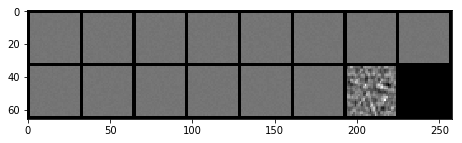

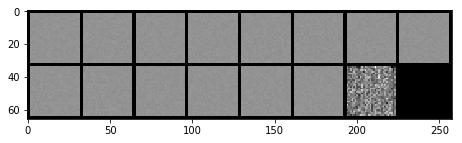

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torchvision import utils

def plotkernel(tensor, figname,ch=0, allkernels=True, nrow=8, padding=2):
    
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.savefig(figname)

convolayer1 = [i for i in model.children()][1]
kernel_unsync = convolayer1.cpu()
kernel_unsync = convolayer1.weight.data.clone()

convolayer2 = [i for i in model.children()][2]
kernel_sync = convolayer2.cpu()
kernel_sync = convolayer2.weight.data.clone()


print("Convolutional 1 \n Convolutional 2")
plotkernel(kernel_unsync, figname = 'CNN1.png')
plotkernel(kernel_sync, figname = 'CNN2.png')

# Matching Pursuit, sequential
Maintenant on intègre MP de manière séquentielle (!= pour stream) avec le modèle.

On utilise toujours la [jolie image](https://www.flickr.com/photos/doug88888/6370387703) de flickr :

In [ ]:
from SparseEdges import SparseEdges
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time

mp = SparseEdges('https://raw.githubusercontent.com/bicv/SparseEdges/master/default_param.py')
mp.pe.N = 2048
mp.pe.MP_alpha=1.
mp.pe.figpath, name = './mp', 'mpnaturalimage'

mp.init()

###si on a les edges de mp.run, on peut les afficher pour la démo 
#import pickle
#edges = pickle.load( open('edges.p', 'rb'))
#fig, a = mp.show_edges(edges, image=image)

On extrait les edges :

In [ ]:
number_edge = 25
img = mp.imread('tiger.jpg')

#gabor saving folder
if not os.path.exists('temp'):
    os.makedirs('temp')
   
for edge in range(number_edge):
    print("Edge %s / %s" %(edge+1, number_edge))
    
    #matching
    if edge == 0 : #init
        C = mp.linear_pyramid(img)
    edge_loc = mp.argmax(C)
    C = mp.backprop(C, edge_loc)
    FT_star = mp.loggabor(edge_loc[0], edge_loc[1], sf_0=mp.sf_0[edge_loc[3]],
                         B_sf=mp.pe.B_sf, theta= mp.theta[edge_loc[2]], B_theta=mp.pe.B_theta)
    im_star = mp.invert(FT_star)
    
    #get FT and save only the LogGabor in a temp folder
    plot = mp.show_FT(FT_star, axis=True)
    fig = plot[0]
    ax = plot[2]
    extent =ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('temp/edge%s.png' % edge, bbox_inches=extent.expanded(0.9,0.8))

    #pursuit
    img = (img - C[edge_loc] * im_star).real
    plt.close(fig) #prevents memory overload

On les transforme en un format compréhensible par le réseau :

In [ ]:
from torchvision import transforms
from PIL import Image
from torch.autograd import Variable

transformations = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
    ])

edge_folders = os.listdir("temp")
edge_img_list = []

for edge in edge_folders :
    edge_img = Image.open("temp/"+edge)
    edge_img_cop = edge_img
    
    edge_img = transformations(edge_img)
    edge_img_list.append((edge_img,np.asarray(edge_img_cop)))


Puis on les classifie et on les compare au MotionClouds d'entrainement :

In [ ]:
output_list = []

for i, (edge, img) in enumerate(edge_img_list):
    edge_to_classify = edge_img_list[i][0]
    edge_to_classify = Variable(edge_to_classify.view(-1,64*64)) #wrap in Variable
    
    output = model(edge_to_classify)
    output = output.cpu() 
    output_list.append((output.data.numpy().argmax()
                        ,edge_img_list[i][1])) #append prediction and edge image for plotting
   
#######################################

 
import os

subfolders = sorted(os.listdir("16_clouds_easy"))
fig_width = 14
fig, axs = plt.subplots(len(output_list), 2,figsize=(fig_width, fig_width/2*len(output_list)))

for i, tup in enumerate(output_list) :
    
    axs[i,0].imshow(output_list[i][1])
    axs[i, 0].text(350, 420, 'Edge', color='white', fontsize=20) #text indicating edge
    
    #opens a motionCloud to display, from the subfolder of the predicted label (output_list[i][0])
    #and does a secondlistdir to get the first image from that subfolder (it's a bit hairy really)
    MC_to_display = Image.open('./16_clouds_easy/%s/%s' % (subfolders[output_list[i][0]],
                                                          os.listdir("16_clouds_easy/%s" % subfolders[output_list[i][0]])[0]))
    #MC_to_display = np.asarray(MC_to_display)
    axs[i,1].imshow(MC_to_display, cmap= 'gray')
    #fig, axs[i, 1] = mp.imshow((MC_to_display),fig=fig, ax=axs[i, 1], norm=False) #MC
    axs[i, 1].text(170, 245, 'Predicted', color='yellow', fontsize=20) #text indicating edge
    

# Matching pursuit, pre-computed
Idem qu'au dessus mais il faut une liste d'edges déjà entièrement calculée :

In [ ]:
from SparseEdges import SparseEdges
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

mp = SparseEdges('https://raw.githubusercontent.com/bicv/SparseEdges/master/default_param.py')
mp.pe.N = 2048
mp.pe.MP_alpha=1.
mp.pe.figpath, name = './mp', 'mpnaturalimage'

image = mp.imread('tiger.jpg')
mp.init()
image = mp.normalize(image, center=True)

In [ ]:
edges, C_res = mp.run_mp(image, verbose=True)
import pickle
pickle.dump(edges, open('edges.p', 'wb'))

In [ ]:
import pickle
edges = pickle.load( open('edges.p', 'rb'))
fig, a = mp.show_edges(edges, image=image)

On extrait les edges de la liste et on les transforme :

In [ ]:
from torchvision import transforms, datasets
from PIL import Image
import numpy as np
from torch.autograd import Variable

edges_list = np.linspace(1,25,25)

fig_width = 14
vmax = 1.
vmax = image.max()

image_rec_list = []

transformations = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
    ])

for i_ax, number_of_edge in enumerate(edges_list):
    number_of_edge = int(number_of_edge)
    
    edges_ = edges[:, number_of_edge-1:number_of_edge][..., np.newaxis]
    
    image_rec = mp.dewhitening(mp.reconstruct(edges_))
    image_plot = image_rec #save them unchanged for latter plotting purposes
    
    plt.imshow(image_rec, cmap = 'gray')

    image_rec = Image.fromarray((image_rec*255).astype('uint8'))

    image_rec = transformations(image_rec)
    image_rec = Variable(image_rec)
    image_rec_list.append((image_rec, image_plot)) 

On classifie et on affiche :

In [ ]:
output_list = []

for i, (edge, img) in enumerate(image_rec_list):
    edge_to_classify = image_rec_list[i][0]
    edge_to_classify = Variable(edge_to_classify.view(-1, sequence_length, input_size)) #wrap in Variable
    
    output = model(edge_to_classify)
    output = output.cpu() #cuda fucks up argmax for some reason
    output_list.append((output.data.numpy().argmax()
                        ,image_rec_list[i][1])) #append prediction and edge image for plotting

    
################################

import os

subfolders = sorted(os.listdir("16_clouds_easy"))
fig_width = 14
fig, axs = plt.subplots(len(output_list), 2,figsize=(fig_width, fig_width/2*len(output_list)))

for i, tup in enumerate(output_list) :
    
    fig, axs[i, 0] = mp.imshow((output_list[i][1]),
                               fig=fig, ax=axs[i, 0], norm=False) #edge
    axs[i, 0].text(120, 144, 'Edge', color='white', fontsize=20) #text indicating edge
    
    #opens a motionCloud to display, from the subfolder of the predicted label (output_list[i][0])
    #and does a secondlistdir to get the first image from that subfolder (it's a bit hairy really)
    MC_to_display = Image.open('./16_clouds_easy/%s/%s' % (subfolders[output_list[i][0]],
                                                          os.listdir("16_clouds_easy/%s" % subfolders[output_list[i][0]])[0]))
    #MC_to_display = np.asarray(MC_to_display)
    axs[i,1].imshow(MC_to_display, cmap= 'gray')
    #fig, axs[i, 1] = mp.imshow((MC_to_display),fig=fig, ax=axs[i, 1], norm=False) #MC
    axs[i, 1].text(170, 245, 'Predicted', color='yellow', fontsize=20) #text indicating edge
    